In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:

from tqdm import tqdm

print(tf.__version__)

# Read in csv files.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

turtle_ids = sorted(np.unique(train.turtle_id)) + ['new_turtle']
turtle_num_lookup = dict(zip(turtle_ids, np.arange(len(turtle_ids))))
turtle_id_lookup = {v: k for k, v in turtle_num_lookup.items()}
train["turtle_num"] = train["turtle_id"].map(turtle_num_lookup)

# Convert image_location strings to lowercase and ensure only allowed strings are present 
for df in [train, test]:
  df.image_location = df.image_location.apply(lambda x: x.lower())
  assert set(df.image_location.unique()) == set(['left', 'right', 'top'])

2.8.0


In [3]:
#Uncomment these to view data info

# train
train.head()
# test.head()
# sample_submission.head()
# train.shape, test.shape, sample_submission.shape
# print(f"There are {train.turtle_id.nunique()} unique turtles in the train set.")

,Unnamed: 0,image_id,image_location,turtle_id,turtle_num
0,0,ID_2RK4WLN8,top,t_id_VP2NW7aV,57
1,1,ID_VVW0QXLX,left,t_id_qZ0iZYsC,91
2,2,ID_RVATH2HZ,right,t_id_3b65X5Lw,8
3,3,ID_2GB90GPS,left,t_id_YjXYTCGC,61
4,4,ID_LM6S0B1M,top,t_id_d6aYXtor,65


In [4]:
#Count which turtles have biggest turtle_id's
train["turtle_id"].value_counts()

t_id_ROFhVsy2    77
t_id_hRzOoJ2t    68
t_id_VP2NW7aV    58
t_id_Kf73l69A    57
t_id_dVQ4x3wz    47
                 ..
t_id_Lhp87PBX    10
t_id_Dv4O8bOM    10
t_id_p77GDtzg     9
t_id_OqU1NWEA     9
t_id_J5dngbNA     8
Name: turtle_id, Length: 100, dtype: int64

In [4]:
from rembg.bg import remove
import numpy as np
import io
from PIL import Image

if not os.path.isdir('turtle_nobg'):
    os.mkdir('turtle_nobg')

# Uncomment the following lines if working with trucated image formats (ex. JPEG / JPG)
# In my case I do give JPEG images as input, so i'll leave it uncommented
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# input_image = 'turtles-original/ID_00KOI3T9.JPG'
# output_image = 'output-image.png'

for row in train.iterrows():
    image_id = row[1]['image_id']
    src = 'turtles-original/'+ image_id + '.jpg'
    dest = 'turtle_nobg/' + image_id + '.png'
    f = np.fromfile(src)
    result = remove(f)
    img = Image.open(io.BytesIO(result)).convert("RGBA")
    img.save(dest)

In [4]:
#This cell migrates everything from the turtles-original folder into their own respective folders
import shutil

#If "turtle_classes" folder doesn't exist, create it 
if not os.path.isdir('turtle_classes'):
    os.mkdir('turtle_classes')

#For each row in train
for row in train.iterrows():
    turtle_id = row[1]['turtle_id']
    image_id = row[1]['image_id']
    if not os.path.isdir('turtle_classes/' + turtle_id):
        os.mkdir('turtle_classes/' + turtle_id)
    #Get file
    src = 'turtles-original/'+ image_id + '.jpg'
    if os.path.exists(src):
        dst = 'turtle_classes/' + turtle_id + '/' + image_id + '.jpg'
        shutil.copyfile(src, dst)

In [6]:
#This cell does the same but for the no_bg folder
import shutil

#If "turtle_classes" folder doesn't exist, create it 
if not os.path.isdir('turtle_classes_nobg'):
    os.mkdir('turtle_classes_nobg')

#For each row in train
for row in train.iterrows():
    turtle_id = row[1]['turtle_id']
    image_id = row[1]['image_id']
    if not os.path.isdir('turtle_classes_nobg/' + turtle_id):
        os.mkdir('turtle_classes_nobg/' + turtle_id)
    #Get file
    src = 'turtle_nobg/'+ image_id + '.png'
    if os.path.exists(src):
        dst = 'turtle_classes_nobg/' + turtle_id + '/' + image_id + '.png'
        shutil.copyfile(src, dst)

In [6]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  'turtle_classes',
  validation_split=0.2,
  subset="training",
  seed=123,
  color_mode="grayscale",
#   image_size=(img_height, img_width), #Resize
  batch_size=batch_size)              

val_ds = tf.keras.utils.image_dataset_from_directory(
  'turtle_classes',
  validation_split=0.2,
  subset="validation",
  seed=123,
  color_mode="grayscale",
#   image_size=(img_height, img_width), #Resize
  batch_size=batch_size)

Found 2145 files belonging to 100 classes.
Using 1716 files for training.
Found 2145 files belonging to 100 classes.
Using 429 files for validation.


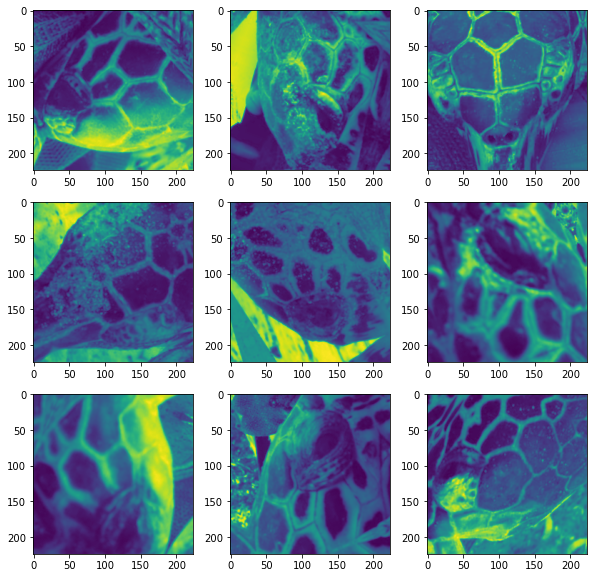

In [12]:
#Data visualization. Comment out layer methods to see different results.
import matplotlib.pyplot as plt
crop_factor = 0.50
IMG_SIZE = 224

image_mod = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
#   tf.keras.layers.RandomCrop(int(IMG_SIZE*crop_factor),int(IMG_SIZE*crop_factor)),
#   tf.keras.layers.RandomContrast(factor=0.5)
])

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = images[i]
    result = image_mod(img)
    _ = plt.imshow(result)


In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 1)
(32,)


In [7]:
#Standardize RGB values
normalization_layer = tf.keras.layers.Rescaling(1./255)

#Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
num_classes = 100
IMG_SIZE = 224
acc=[]

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
#   tf.keras.layers.RandomCrop(int(IMG_SIZE*0.95),int(IMG_SIZE*0.95)),
#   tf.keras.layers.RandomContrast(factor=0.2),
#   tf.keras.layers.random_brightness(x, 0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes),
])

In [9]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [14]:
epoch_log = {
"accuracy": [],
"val_loss": []
}
log_acc = tf.keras.callbacks.LambdaCallback(
on_epoch_end=lambda epochs, logs: epoch_log["accuracy"].append(logs.get('accuracy')))
log_loss = tf.keras.callbacks.LambdaCallback(
on_epoch_end=lambda epochs, logs: epoch_log["val_loss"].append(logs.get('val_loss')))
model.fit(
train_ds,
validation_data=val_ds,
epochs=5,
callbacks=[log_acc, log_loss]
)

Epoch 1/5
54/54 [==============================] - 30s 551ms/step - loss: 4.4848 - accuracy: 0.0297 - val_loss: 4.4752 - val_accuracy: 0.0396
Epoch 2/5
54/54 [==============================] - 29s 539ms/step - loss: 4.4706 - accuracy: 0.0321 - val_loss: 4.4617 - val_accuracy: 0.0396
Epoch 3/5
54/54 [==============================] - 29s 543ms/step - loss: 4.4586 - accuracy: 0.0286 - val_loss: 4.4548 - val_accuracy: 0.0396
Epoch 4/5
54/54 [==============================] - 30s 551ms/step - loss: 4.4444 - accuracy: 0.0350 - val_loss: 4.4493 - val_accuracy: 0.0396
Epoch 5/5
54/54 [==============================] - 29s 543ms/step - loss: 4.4268 - accuracy: 0.0338 - val_loss: 4.4498 - val_accuracy: 0.0420


In [17]:
epoch_log["accuracy"][len(epoch_log["accuracy"])-1]

0.03379953280091286

In [27]:

epoch_log = {
    "accuracy": [],
    "val_loss": []
}
def add_to_epoch_log(accuracy, val_lost):
    epoch_log["accuracy"].append(accuracy)
    epoch_log["val_loss"].append(val_lost)

# lc = tf.keras.callbacks.LambdaCallback(  on_epoch_end=lambda epochs,logs:acc.append([logs.get('accuracy'), logs.get('val_loss')]))
lc = tf.keras.callbacks.LambdaCallback(  on_epoch_end=lambda epochs,logs:add_to_epoch_log(logs.get('accuracy'), logs.get('val_loss')))

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5,
  callbacks = [lc]
)

Epoch 1/5
54/54 [==============================] - 30s 559ms/step - loss: 4.4569 - accuracy: 0.0355 - val_loss: 4.4611 - val_accuracy: 0.0443
Epoch 2/5
54/54 [==============================] - 30s 562ms/step - loss: 4.4561 - accuracy: 0.0338 - val_loss: 4.4634 - val_accuracy: 0.0350
Epoch 3/5
54/54 [==============================] - 29s 538ms/step - loss: 4.4532 - accuracy: 0.0361 - val_loss: 4.4582 - val_accuracy: 0.0256
Epoch 4/5
54/54 [==============================] - 29s 537ms/step - loss: 4.4533 - accuracy: 0.0309 - val_loss: 4.4602 - val_accuracy: 0.0396
Epoch 5/5
54/54 [==============================] - 30s 558ms/step - loss: 4.4434 - accuracy: 0.0355 - val_loss: 4.4511 - val_accuracy: 0.0396


{'accuracy': [0.035547785460948944,
  0.03379953280091286,
  0.03613053634762764,
  0.030885780230164528,
  0.035547785460948944],
 'val_loss': [4.4611310958862305,
  4.463392734527588,
  4.4582109451293945,
  4.460198879241943,
  4.451114654541016]}

In [30]:
max(epoch_log["accuracy"])
max(epoch_log["val_loss"])

4.463392734527588